In [7]:

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

RuntimeError: Physical devices cannot be modified after being initialized

In [3]:
configproto = tf.compat.v1.ConfigProto() 
configproto.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=configproto) 
tf.compat.v1.keras.backend.set_session(sess)

In [4]:
data = tf.keras.utils.image_dataset_from_directory('deepfake_training', batch_size=32)

Found 1010786 files belonging to 2 classes.


In [5]:
data_iterator = data.as_numpy_iterator()

In [6]:
batch = data_iterator.next()

In [7]:
batch[0].shape

(32, 256, 256, 3)

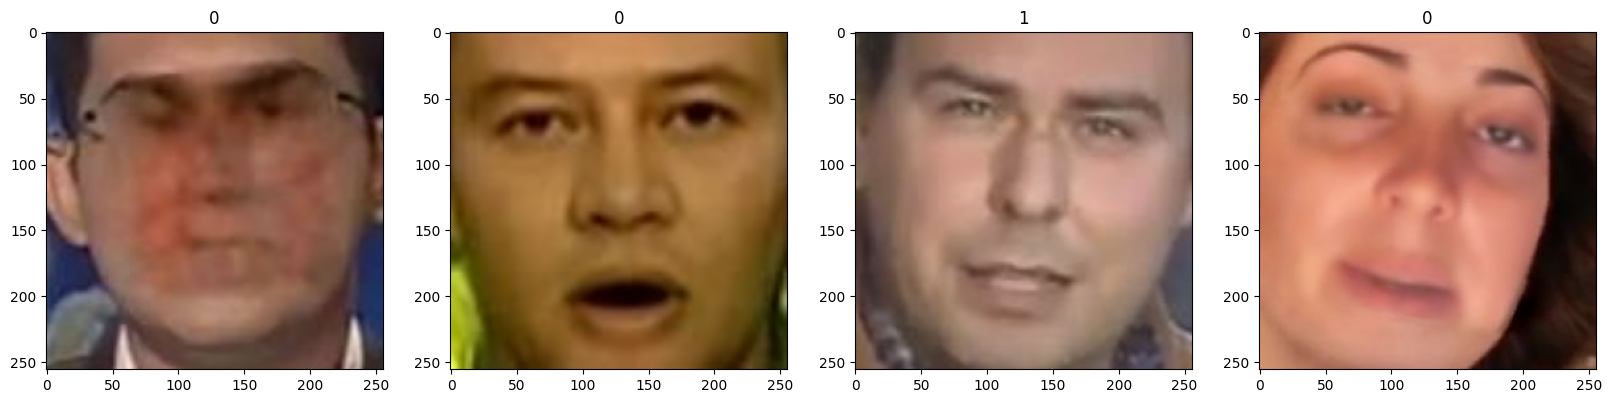

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [9]:
scaled_data = data.map(lambda x,y: (x/255, y))

In [10]:
scaled_iterator = scaled_data.as_numpy_iterator()

In [11]:
batch = scaled_iterator.next()

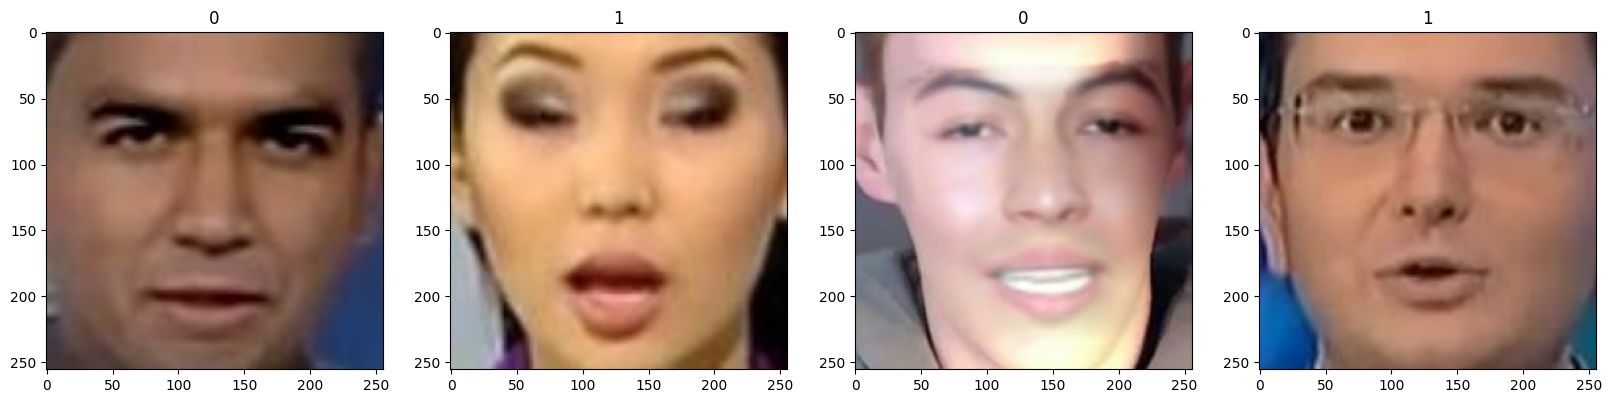

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [13]:
len(scaled_data)

31588

In [20]:
train_size = int(len(scaled_data)*.7)+1
val_size = int(len(scaled_data)*.2)+1
test_size = int(len(scaled_data)*.1)
print(train_size+val_size+test_size)

31588


In [21]:
train = scaled_data.take(train_size)
val = scaled_data.skip(train_size).take(val_size)
test = scaled_data.skip(train_size+val_size).take(test_size)

In [22]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

In [23]:
vgg = VGG19(input_shape=(256, 256, 3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False

In [24]:
x = Flatten()(vgg.output)
x = Dense(256, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)

model = Model(inputs=vgg.input, outputs=prediction)

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [26]:
model.compile(
  loss='binary_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='max',verbose=1,patience=5)

In [28]:
checkpoint_maker = tf.keras.callbacks.ModelCheckpoint("./checkpoints", 
                                     monitor='val_loss', 
                                     verbose=0, 
                                     save_best_only=True,
                                     save_weights_only=False, 
                                     mode='auto', 
                                     save_freq='epoch')

In [29]:
logging = tf.keras.callbacks.TensorBoard(log_dir='log_dir',
                                 histogram_freq=0, 
                                 write_graph=True, 
                                 write_images=False,    
                                 update_freq='epoch', 
                                 profile_batch=2, 
                                 embeddings_freq=0,    
                                 embeddings_metadata=None)

In [30]:
history = model.fit(train, validation_data=val, epochs=100, callbacks=[early_stop, checkpoint_maker, logging], batch_size=32,shuffle=True)

Epoch 1/100
22112/22112 [==============================] - ETA: 0s - loss: 0.1669 - accuracy: 0.9321

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


22112/22112 [==============================] - 16778s 758ms/step - loss: 0.1669 - accuracy: 0.9321 - val_loss: 0.1292 - val_accuracy: 0.9479
Epoch 2/100
22112/22112 [==============================] - ETA: 0s - loss: 0.0939 - accuracy: 0.9634

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


22112/22112 [==============================] - 18321s 828ms/step - loss: 0.0939 - accuracy: 0.9634 - val_loss: 0.0660 - val_accuracy: 0.9753
Epoch 3/100
22112/22112 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.9719

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


22112/22112 [==============================] - 15327s 693ms/step - loss: 0.0738 - accuracy: 0.9719 - val_loss: 0.0587 - val_accuracy: 0.9779
Epoch 4/100
22112/22112 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9771

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


22112/22112 [==============================] - 14718s 665ms/step - loss: 0.0603 - accuracy: 0.9771 - val_loss: 0.0566 - val_accuracy: 0.9792
Epoch 5/100
22112/22112 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.9802

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


22112/22112 [==============================] - 14975s 677ms/step - loss: 0.0522 - accuracy: 0.9802 - val_loss: 0.0524 - val_accuracy: 0.9813
Epoch 6/100
22112/22112 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9824

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


22112/22112 [==============================] - 14719s 666ms/step - loss: 0.0468 - accuracy: 0.9824 - val_loss: 0.0377 - val_accuracy: 0.9869
Epoch 6: early stopping


In [31]:
model.save("large_model_deepfake_10lakh_v1.h5")

 history = model.fit(train,
  validation_data=val,
  epochs=100,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

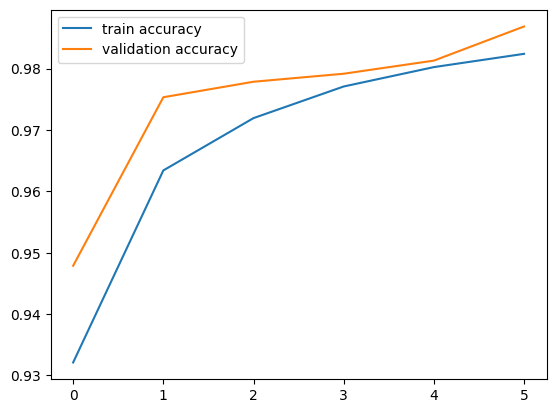

In [32]:
plt.plot(history.history['accuracy'], label='train accuracy')

plt.plot(history.history['val_accuracy'], label='validation accuracy')

plt.legend()

plt.savefig('deepfake_dtr_accuracy.png')

plt.show()

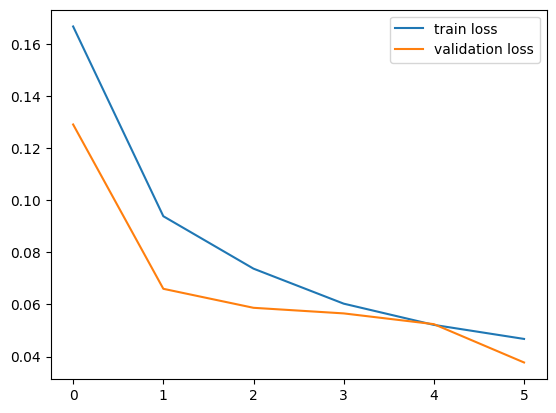

In [33]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.savefig('deepfake_dtr_loss.png')
plt.show()

In [37]:
model = load_model('large_model_deepfake_10lakh_v1.h5')

In [ ]:
model.evaluate(test,batch_size=32)


In [1]:
from tensorflow.keras.models import load_model

In [2]:
import os
import cv2
import matplotlib.pyplot as plt

In [3]:
new_model = load_model('large_model_deepfake_10lakh_v1.h5')

In [9]:
new_model

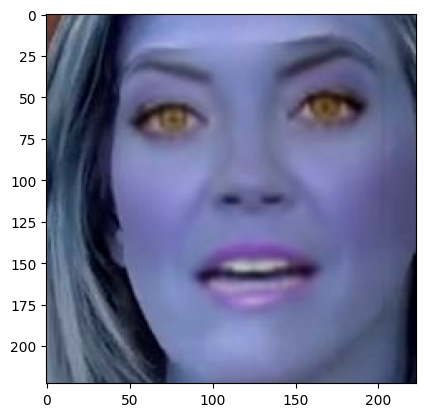

In [36]:
img = cv2.imread('face_fake72.jpg')
plt.imshow(img)
plt.show()

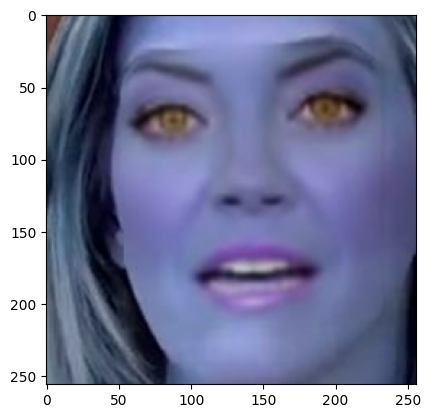

In [37]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))

In [38]:
pred = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 20ms/step


In [39]:
pred

array([[0.00236144]], dtype=float32)

In [ ]:
# the cloaser the value to 0, the closer the predcition saying the image is a deepfake